In [31]:
!pip -q install --upgrade pip
!pip -q install ultralytics==8.3.0 lxml tqdm matplotlib pandas scikit-learn pyyaml
!pip -q install opencv-python-headless==4.9.0.74


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.4 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.11.41, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.5.5.62, 4.7.0.68, 4.8.0.74
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.9.0.74 (from versions: 3.4.10.37, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88)
ERROR: No matching distribution found for opencv-python-headless==4.9.0.74


In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
DATASET_PATH = "/content/drive/MyDrive/ColabData/Hard-Hat"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
YOLO_LABELS_DIR = os.path.join(DATASET_PATH, "labels")
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

print("DATASET_PATH:", DATASET_PATH)
print("IMAGES_PATH exists?", os.path.exists(IMAGES_PATH))
print("ANNOTATIONS_PATH exists?", os.path.exists(ANNOTATIONS_PATH))


Mounted at /content/drive
DATASET_PATH: /content/drive/MyDrive/ColabData/Hard-Hat
IMAGES_PATH exists? True
ANNOTATIONS_PATH exists? True


In [33]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from tqdm import tqdm

def parse_annotation(annotation_path, images_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    image_data = []
    filename = root.find("filename").text
    img_path = os.path.join(images_path, filename)
    # read width/height from XML's <size>
    size = root.find("size")
    if size is not None:
        width = int(size.find("width").text)
        height = int(size.find("height").text)
    else:
        width = None
        height = None
    for obj in root.findall("object"):
        name = obj.find("name").text
        b = obj.find("bndbox")
        xmin = int(float(b.find("xmin").text))
        ymin = int(float(b.find("ymin").text))
        xmax = int(float(b.find("xmax").text))
        ymax = int(float(b.find("ymax").text))
        image_data.append({
            "image_path": img_path,
            "label": name,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "width": width,
            "height": height
        })
    return image_data

all_annotations = []
xml_files = [f for f in os.listdir(ANNOTATIONS_PATH) if f.endswith(".xml")]
for xml_file in tqdm(xml_files, desc="Parsing XMLs"):
    xml_path = os.path.join(ANNOTATIONS_PATH, xml_file)
    all_annotations.extend(parse_annotation(xml_path, IMAGES_PATH))

df = pd.DataFrame(all_annotations)
print("Total objects:", len(df))
print("Total images:", df['image_path'].nunique())
df.head()


Parsing XMLs: 100%|██████████| 5000/5000 [01:03<00:00, 78.54it/s] 

Total objects: 25502
Total images: 5000


,image_path,label,xmin,ymin,xmax,ymax,width,height
0,/content/drive/MyDrive/ColabData/Hard-Hat/imag...,helmet,76,131,102,155,416,416
1,/content/drive/MyDrive/ColabData/Hard-Hat/imag...,helmet,181,168,202,191,416,416
2,/content/drive/MyDrive/ColabData/Hard-Hat/imag...,helmet,307,133,336,162,416,416
3,/content/drive/MyDrive/ColabData/Hard-Hat/imag...,helmet,358,139,376,160,416,416
4,/content/drive/MyDrive/ColabData/Hard-Hat/imag...,helmet,292,189,333,229,416,415


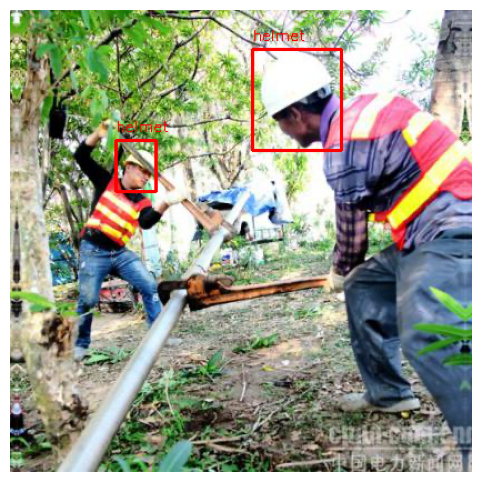

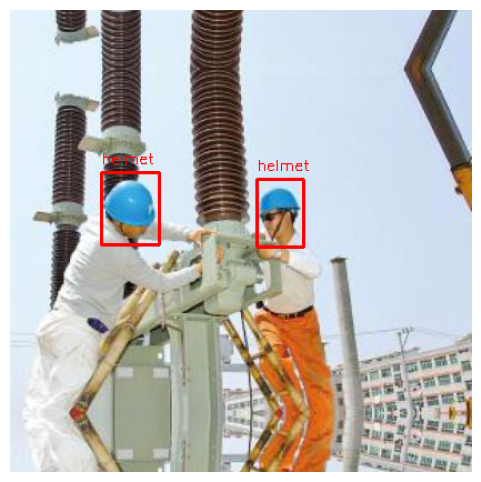

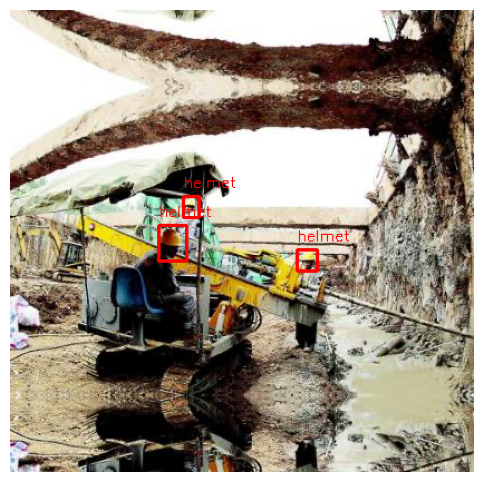

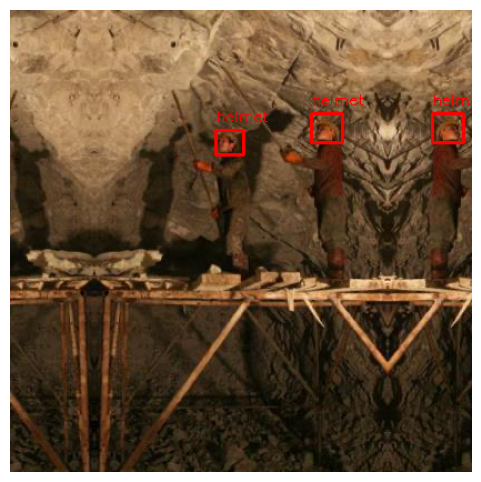

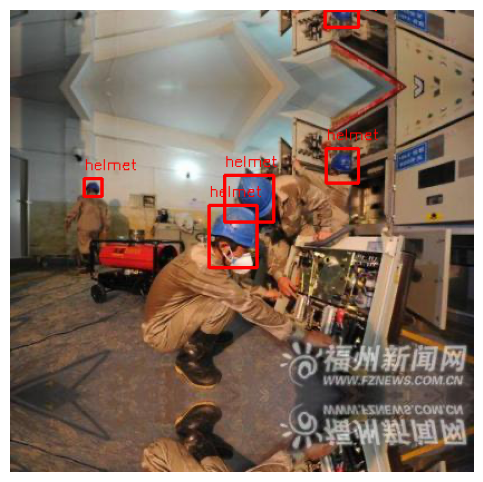

In [34]:
import random
import cv2
from matplotlib import pyplot as plt

def visualize_sample(img_path, df, figsize=(6,6)):
    ann = df[df['image_path']==img_path]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for _, r in ann.iterrows():
        cv2.rectangle(img, (r['xmin'], r['ymin']), (r['xmax'], r['ymax']), (255,0,0), 2)
        cv2.putText(img, r['label'], (r['xmin'], max(0, r['ymin']-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,0), 1)
    plt.figure(figsize=figsize)
    plt.imshow(img); plt.axis('off')

sample_imgs = random.sample(list(df['image_path'].unique()), min(5, df['image_path'].nunique()))
for p in sample_imgs:
    visualize_sample(p, df)


In [35]:
classes = ["helmet", "head", "person"]
class_to_id = {c:i for i,c in enumerate(classes)}

os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

for img_path, group in df.groupby("image_path"):
    w = int(group.iloc[0]['width'])
    h = int(group.iloc[0]['height'])
    lines = []
    for _, row in group.iterrows():
        cid = class_to_id[row['label']]
        x_center = ((row['xmin'] + row['xmax'])/2) / w
        y_center = ((row['ymin'] + row['ymax'])/2) / h
        width = (row['xmax'] - row['xmin']) / w
        height = (row['ymax'] - row['ymin']) / h
        lines.append(f"{cid} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    txt_name = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
    with open(os.path.join(YOLO_LABELS_DIR, txt_name), "w") as f:
        f.write("\n".join(lines))

print("YOLO label files written to:", YOLO_LABELS_DIR)
sample_label = os.path.join(YOLO_LABELS_DIR, os.path.splitext(os.path.basename(sample_imgs[0]))[0] + ".txt")
print("Sample label file:", sample_label)
!sed -n '1,10p' "{sample_label}"


YOLO label files written to: /content/drive/MyDrive/ColabData/Hard-Hat/labels
Sample label file: /content/drive/MyDrive/ColabData/Hard-Hat/labels/hard_hat_workers3594.txt
0 0.620192 0.193510 0.192308 0.218750
0 0.271635 0.336538 0.086538 0.110577

In [36]:
from sklearn.model_selection import train_test_split
import numpy as np

all_images = np.array(df['image_path'].unique())
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=42)  # 0.1 total

print("Counts -> Train:", len(train_imgs), "Val:", len(val_imgs), "Test:", len(test_imgs))

train_list = os.path.join(DATASET_PATH, "train.txt")
val_list   = os.path.join(DATASET_PATH, "val.txt")
test_list  = os.path.join(DATASET_PATH, "test.txt")

with open(train_list, "w") as f:
    f.write("\n".join(train_imgs))
with open(val_list, "w") as f:
    f.write("\n".join(val_imgs))
with open(test_list, "w") as f:
    f.write("\n".join(test_imgs))

print("Saved train/val/test list files at:", DATASET_PATH)


Counts -> Train: 3500 Val: 1000 Test: 500
Saved train/val/test list files at: /content/drive/MyDrive/ColabData/Hard-Hat


In [37]:
import yaml
data_yaml = {
    "train": os.path.join(DATASET_PATH, "train.txt"),
    "val":   os.path.join(DATASET_PATH, "val.txt"),
    "test":  os.path.join(DATASET_PATH, "test.txt"),
    "names": classes
}
yaml_path = os.path.join(DATASET_PATH, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f)
print("Wrote:", yaml_path)
print(open(yaml_path).read())


Wrote: /content/drive/MyDrive/ColabData/Hard-Hat/data.yaml
names:
- helmet
- head
- person
test: /content/drive/MyDrive/ColabData/Hard-Hat/test.txt
train: /content/drive/MyDrive/ColabData/Hard-Hat/train.txt
val: /content/drive/MyDrive/ColabData/Hard-Hat/val.txt



In [38]:
from collections import Counter
cnt = Counter(df['label'])
print("Boxes per class:", dict(cnt))
print("Avg boxes per image:", df.groupby('image_path').size().mean())


Boxes per class: {'helmet': 18966, 'head': 5785, 'person': 751}
Avg boxes per image: 5.1004


In [42]:
from ultralytics import YOLO
import os

yaml_path = os.path.join(DATASET_PATH, "data.yaml")

project_name = "hardhat_runs"

model = YOLO("yolov8s.pt")

model.train(
    data=yaml_path,
    epochs=30,
    imgsz=640,
    batch=16,
    lr0=0.001,
    patience=10,
    project=project_name,
    name="hardhat_yolov8s",
    exist_ok=True
)


New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/ColabData/Hard-Hat/data.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=hardhat_runs, name=hardhat_yolov8s, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hkay-321-hadi (hkay-321-hadi-lebanese-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 185MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/ColabData/Hard-Hat/labels... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [18:56<00:00,  3.08it/s]


train: New cache created: /content/drive/MyDrive/ColabData/Hard-Hat/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/ColabData/Hard-Hat/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]


val: New cache created: /content/drive/MyDrive/ColabData/Hard-Hat/labels.cache
Plotting labels to hardhat_runs/hardhat_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to hardhat_runs/hardhat_yolov8s
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       4.3G      1.497      1.866      1.221         80        640: 100%|██████████| 219/219 [02:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


                   all       1000       5000      0.902      0.514      0.571      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.16G      1.432      1.191      1.207        130        640: 100%|██████████| 219/219 [01:41<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


                   all       1000       5000      0.905      0.517      0.571       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.16G      1.421      1.074      1.203         68        640: 100%|██████████| 219/219 [01:41<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


                   all       1000       5000        0.9      0.512      0.566      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.27G      1.412      1.003      1.211         87        640: 100%|██████████| 219/219 [01:40<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


                   all       1000       5000      0.922      0.539      0.591      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.04G      1.375     0.9495      1.197         98        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


                   all       1000       5000      0.909       0.53      0.585       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.03G      1.344     0.8812       1.18         54        640: 100%|██████████| 219/219 [01:41<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.78it/s]


                   all       1000       5000      0.932      0.556      0.603      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.15G       1.34     0.8655      1.178         82        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


                   all       1000       5000      0.932      0.559      0.609      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.03G       1.32     0.8364      1.165         89        640: 100%|██████████| 219/219 [01:38<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


                   all       1000       5000      0.942      0.552      0.611      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.16G      1.319     0.8393      1.158         71        640: 100%|██████████| 219/219 [01:39<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


                   all       1000       5000      0.937      0.571      0.614      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.03G      1.306     0.7926      1.152         61        640: 100%|██████████| 219/219 [01:39<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


                   all       1000       5000      0.937       0.56      0.614      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.13G      1.305     0.7947      1.149         67        640: 100%|██████████| 219/219 [01:39<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


                   all       1000       5000      0.936      0.568      0.617      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.05G      1.285      0.783       1.15         87        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


                   all       1000       5000      0.941      0.573      0.621      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.03G      1.261     0.7473      1.132         73        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


                   all       1000       5000      0.954      0.569      0.626      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.15G      1.259     0.7587       1.13         82        640: 100%|██████████| 219/219 [01:40<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]

                   all       1000       5000      0.947      0.576      0.625      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.06G      1.244     0.7246      1.121         67        640: 100%|██████████| 219/219 [01:40<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


                   all       1000       5000       0.94      0.585      0.623        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.16G      1.243     0.7321      1.119         84        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]

                   all       1000       5000      0.946      0.576      0.626      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       4.2G      1.216     0.7048       1.11         56        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]

                   all       1000       5000      0.942      0.587      0.631      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.13G      1.225     0.6932       1.11         61        640: 100%|██████████| 219/219 [01:40<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


                   all       1000       5000      0.947       0.58      0.629      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.15G      1.223     0.6806      1.103        102        640: 100%|██████████| 219/219 [01:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


                   all       1000       5000      0.941      0.588      0.628      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.15G      1.193     0.6771      1.099         95        640: 100%|██████████| 219/219 [01:39<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


                   all       1000       5000      0.947      0.585      0.632      0.412
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         4G      1.208     0.6114      1.121         45        640: 100%|██████████| 219/219 [01:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


                   all       1000       5000      0.948      0.583      0.632      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.06G      1.192     0.5943      1.117         62        640: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]

                   all       1000       5000      0.953      0.584      0.634      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.14G       1.18     0.5808      1.102         51        640: 100%|██████████| 219/219 [01:39<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]

                   all       1000       5000       0.95      0.586      0.633      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.15G      1.168     0.5747        1.1         52        640: 100%|██████████| 219/219 [01:37<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


                   all       1000       5000      0.946      0.593      0.634      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.03G      1.156     0.5577      1.093         52        640: 100%|██████████| 219/219 [01:38<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]

                   all       1000       5000      0.953      0.589      0.635      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.17G      1.149     0.5545      1.096         61        640: 100%|██████████| 219/219 [01:36<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


                   all       1000       5000      0.951      0.594      0.636      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.12G      1.136     0.5436      1.087         60        640: 100%|██████████| 219/219 [01:45<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]

                   all       1000       5000      0.955      0.592      0.637       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.02G      1.122     0.5316       1.08         98        640: 100%|██████████| 219/219 [01:38<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


                   all       1000       5000      0.956      0.592      0.636      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         4G      1.111     0.5192      1.072        129        640: 100%|██████████| 219/219 [01:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


                   all       1000       5000      0.956       0.59      0.635      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.15G      1.096     0.5106      1.067         70        640: 100%|██████████| 219/219 [01:40<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


                   all       1000       5000      0.955      0.593      0.636      0.424

30 epochs completed in 1.013 hours.
Optimizer stripped from hardhat_runs/hardhat_yolov8s/weights/last.pt, 19.9MB
Optimizer stripped from hardhat_runs/hardhat_yolov8s/weights/best.pt, 19.9MB

Validating hardhat_runs/hardhat_yolov8s/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 186 layers, 9,828,825 parameters, 0 gradients, 23.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


                   all       1000       5000      0.957      0.591      0.636      0.424
                helmet        914       3676      0.949      0.904       0.96      0.644
                  head        181       1148      0.921      0.868      0.921      0.612
                person         35        176          1          0     0.0275     0.0153
Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to hardhat_runs/hardhat_yolov8s


lr/pg0,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▁▁▃▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇███████████
metrics/mAP50-95(B),▁▁▁▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇█▇█████
metrics/precision(B),▁▂▁▄▂▅▅▆▆▆▅▆█▇▆▇▆▇▆▇▇█▇▇█▇████
metrics/recall(B),▁▁▁▃▃▅▅▄▆▅▆▆▆▆▇▆▇▇█▇▇▇▇███████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c98bbdc35f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [47]:
val_folder = os.path.join(IMAGES_PATH, "val")
os.makedirs(val_folder, exist_ok=True)


In [48]:
import shutil
import random

all_images = [f for f in os.listdir(IMAGES_PATH) if f.endswith((".jpg", ".png"))]
random.shuffle(all_images)

val_split = int(0.2 * len(all_images))
for img in all_images[:val_split]:
    shutil.move(os.path.join(IMAGES_PATH, img), os.path.join(val_folder, img))


In [49]:
import os
best_model_path = os.path.join(project_name, "hardhat_yolov8s", "weights", "best.pt")
print("Best model:", best_model_path)

model = YOLO(best_model_path)

# Evaluate metrics
metrics = model.val(data=yaml_path, imgsz=640, batch=16)
print("Validation metrics:", metrics)

# Predict and save images with bounding boxes
output_dir = os.path.join(DATASET_PATH, "inference_results")
os.makedirs(output_dir, exist_ok=True)

# Correct path to validation images
val_images = val_folder  # <-- this is the correct folder now
model.predict(source=val_images, save=True, save_txt=False, imgsz=640, conf=0.25, project=output_dir, name="val_preds")

print("Predictions saved to:", os.path.join(output_dir, "val_preds"))

Best model: hardhat_runs/hardhat_yolov8s/weights/best.pt
Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 186 layers, 9,828,825 parameters, 0 gradients, 23.3 GFLOPs


val: Scanning /content/drive/MyDrive/ColabData/Hard-Hat/labels... 803 images, 0 backgrounds, 197 corrupt: 100%|██████████| 1000/1000 [00:04<00:00, 202.70it/s]

val: WARNING ⚠️ /content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1023.png: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1023.png'
val: WARNING ⚠️ /content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1149.png: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1149.png'
val: WARNING ⚠️ /content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1152.png: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1152.png'
val: WARNING ⚠️ /content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1153.png: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabData/Hard-Hat/images/hard_hat_workers1153.png'
val: WARNING ⚠️ /content/drive/MyDrive/ColabData/Hard-Hat/images

val: New cache created: /content/drive/MyDrive/ColabData/Hard-Hat/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:21<00:00,  2.41it/s]


                   all        803       4051      0.958      0.599      0.641      0.426
                helmet        729       2973      0.947      0.911      0.961      0.644
                  head        147        941      0.926      0.886      0.932      0.617
                person         26        137          1          0     0.0283     0.0169
Speed: 0.6ms preprocess, 8.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val3
Validation metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c996aa10ce0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.01101

In [50]:
export_dir = os.path.join(DATASET_PATH, "exported")
os.makedirs(export_dir, exist_ok=True)

model.export(format="onnx", imgsz=640, opset=12, name="hardhat_yolov8s", project=export_dir)
print("Model exported to:", os.path.join(export_dir, "hardhat_yolov8s"))


Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'hardhat_runs/hardhat_yolov8s/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (19.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 251.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 36.2 MB/s  0:00:07


requirements: AutoUpdate success ✅ 32.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 12...
ONNX: slimming with onnxslim 0.1.34...
ONNX: export success ✅ 39.6s, saved as 'hardhat_runs/hardhat_yolov8s/weights/best.onnx' (37.7 MB)

Export complete (42.8s)
Results saved to /content/hardhat_runs/hardhat_yolov8s/weights
Predic

In [51]:
!pip -q install gradio

import gradio as gr
import numpy as np

model = YOLO(best_model_path)

def infer_image(img):
    results = model.predict(source=img, conf=0.25, imgsz=640)
    out = results[0].plot()
    return out[..., ::-1]
demo = gr.Interface(
    fn=infer_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="Hard Hat Detector",
    description="Upload an image to detect helmets"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://70af7dc44f1539324c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title></title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }
        table { border-collapse: collapse; width: 100%; margin-bottom: 20px; }
        th, td { border: 1px solid #ccc; padding: 8px; text-align: center; }
        th { background-color: #f2f2f2; }
        h2 { color: #333; margin-top: 40px; }
        .insights { background-color: #f9f9f9; padding: 15px; border-left: 4px solid #4CAF50; }
    </style>
</head>
<body>

<h1>YOLOv8 Detection Results</h1>

<h2>1. Training & Validation Performance</h2>
<table>
    <tr>
        <th>Metric</th>
        <th>Value</th>
    </tr>
    <tr><td>Training box loss</td><td>1.096</td></tr>
    <tr><td>Training class loss</td><td>0.511</td></tr>
    <tr><td>Training DFL loss</td><td>1.067</td></tr>
    <tr><td>Validation box loss</td><td>1.224</td></tr>
    <tr><td>Validation class loss</td><td>0.574</td></tr>
    <tr><td>Validation DFL loss</td><td>1.142</td></tr>
    <tr><td>Overall precision</td><td>0.957</td></tr>
    <tr><td>Overall recall</td><td>0.591</td></tr>
    <tr><td>Overall mAP50</td><td>0.636</td></tr>
    <tr><td>Overall mAP50-95</td><td>0.424</td></tr>
    <tr><td>Model parameters</td><td>9.84M</td></tr>
    <tr><td>Inference speed per frame</td><td>11.1 ms (~90 FPS)</td></tr>
</table>

<h2>2. Class-wise Performance</h2>
<table>
    <tr>
        <th>Class</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>mAP50</th>
        <th>mAP50-95</th>
        <th>Interpretation</th>
    </tr>
    <tr><td>Helmet</td><td>0.949</td><td>0.904</td><td>0.960</td><td>0.644</td><td>Excellent detection; high confidence and coverage.</td></tr>
    <tr><td>Head</td><td>0.921</td><td>0.868</td><td>0.921</td><td>0.612</td><td>Very good performance; most heads are correctly detected.</td></tr>
    <tr><td>Person</td><td>1.0</td><td>0</td><td>0.027</td><td>0.015</td><td>Poor detection due to very few examples (35 images, 176 instances).</td></tr>
</table>

<h2>3. Overall Insights</h2>
<div class="insights">
    <ul>
        <li><strong>Helmet and head detection:</strong> Model is accurate and reliable. Suitable for real-time safety monitoring applications.</li>
        <li><strong>Person detection:</strong> Limited by dataset size. Adding more labeled images of people or applying augmentation will likely improve performance.</li>
        <li><strong>Real-time performance:</strong> With ~11 ms per frame, the model can run at ~90 FPS on a Tesla T4 GPU, making it feasible for live video monitoring.</li>
    </ul>

  
</div>

</body>
</html>
